## Import libraries

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score,precision_recall_fscore_support
from sklearn.metrics import f1_score,roc_auc_score
from sklearn.ensemble import RandomForestClassifier,ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier
import xgboost as xgb
from xgboost import plot_importance

## Read sampled dataset

In [3]:
df=pd.read_csv('./CAN_INTRUSION_sample_km.csv')

In [4]:
df=df.dropna()

In [5]:
X = df.drop(['Label'],axis=1).values
y = df.iloc[:, -1].values.reshape(-1,1)
y=np.ravel(y)

In [6]:
df.Label.value_counts()

Label
4    29667
2     4046
3     3918
0     3187
1     1456
Name: count, dtype: int64

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X,y, train_size = 0.7, test_size = 0.3, random_state = 0,stratify = y)

## Feature engineering

### Feature selection by information gain

In [8]:
from sklearn.feature_selection import mutual_info_classif
importances = mutual_info_classif(X_train, y_train)

In [9]:
features = df.dtypes[df.dtypes != 'object'].index

In [10]:
# calculate the sum of importance scores
f_list = sorted(zip(map(lambda x: round(x, 4), importances), features), reverse=True)
Sum = 0
fs = []
for i in range(0, len(f_list)):
    Sum = Sum + f_list[i][0]
    fs.append(f_list[i][1])

In [11]:
# select the important features from top to bottom until the accumulated importance reaches 90%
f_list2 = sorted(zip(map(lambda x: round(x, 4), importances/Sum), features), reverse=True)
Sum2 = 0
fs = []
for i in range(0, len(f_list2)):
    Sum2 = Sum2 + f_list2[i][0]
    fs.append(f_list2[i][1])
    if Sum2>=0.9:
        break

In [12]:
X_fs = df[fs].values

In [13]:
X_fs.shape

(42274, 8)

### Feature selection by Fast Correlation Based Filter (FCBF)

The module is imported from the GitHub repo: https://github.com/SantiagoEG/FCBF_module

In [14]:
from FCBF_module import FCBF, FCBFK, FCBFiP, get_i
fcbf = FCBFK(k = 20)

In [15]:
X_fss = fcbf.fit_transform(X_fs,y)

In [16]:
X_fss.shape

(42274, 8)

### Re-split train & test sets after feature selection

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X_fss,y, train_size = 0.7, test_size = 0.3, random_state = 0,stratify = y)

In [18]:
X_train.shape

(29591, 8)

In [19]:
pd.Series(y_train).value_counts()

4    20766
2     2832
3     2743
0     2231
1     1019
Name: count, dtype: int64

### Training four base learners: decision tree, random forest, extra trees, XGBoost

#### Apply XGBoost

Accuracy of XGBoost: 0.8077741859181582
Precision of XGBoost: 0.7981195432432769
Recall of XGBoost: 0.8077741859181582
F1-score of XGBoost: 0.7769325339374455
              precision    recall  f1-score   support

           0       0.77      0.33      0.46       956
           1       0.65      0.31      0.42       437
           2       0.85      0.35      0.49      1214
           3       0.62      0.43      0.51      1175
           4       0.82      1.00      0.90      8901

    accuracy                           0.81     12683
   macro avg       0.74      0.48      0.56     12683
weighted avg       0.80      0.81      0.78     12683



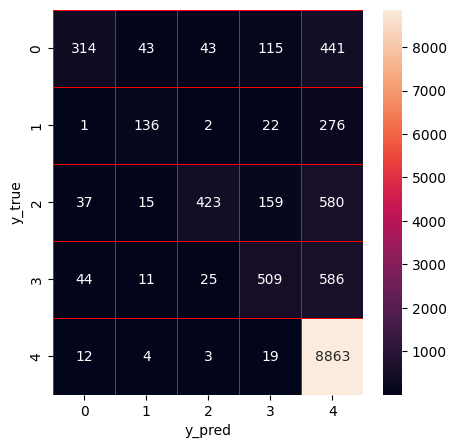

In [20]:
xg = xgb.XGBClassifier(n_estimators = 10)
xg.fit(X_train,y_train)
xg_score=xg.score(X_test,y_test)
y_predict=xg.predict(X_test)
y_true=y_test

print('Accuracy of XGBoost: '+ str(xg_score))

precision,recall,fscore,none= precision_recall_fscore_support(y_true, y_predict, average='weighted')

print('Precision of XGBoost: '+(str(precision)))
print('Recall of XGBoost: '+(str(recall)))
print('F1-score of XGBoost: '+(str(fscore)))

print(classification_report(y_true,y_predict))

cm=confusion_matrix(y_true,y_predict)
f,ax=plt.subplots(figsize=(5,5))

sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

#### Hyperparameter optimization (HPO) of XGBoost using Bayesian optimization with tree-based Parzen estimator (BO-TPE)
Based on the GitHub repo for HPO: https://github.com/LiYangHart/Hyperparameter-Optimization-of-Machine-Learning-Algorithms

In [21]:
X_train_hpo, X_val_hpo, y_train_hpo, y_val_hpo = train_test_split(X_train, y_train, train_size=0.9, test_size=0.1, random_state=0, stratify=y_train)

In [22]:
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
from sklearn.model_selection import cross_val_score, StratifiedKFold

def objective(params):
    params = {
        'n_estimators': int(params['n_estimators']),
        'max_depth': int(params['max_depth']),
        'learning_rate':  abs(float(params['learning_rate'])),

    }
    clf = xgb.XGBClassifier( **params)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_val_hpo)
    score = accuracy_score(y_val_hpo, y_pred)

    return {'loss':-score, 'status': STATUS_OK }

space = {
    'n_estimators': hp.quniform('n_estimators', 10, 100, 5),
    'max_depth': hp.quniform('max_depth', 4, 100, 1),
    'learning_rate': hp.normal('learning_rate', 0.01, 0.9),
}

best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=20)
print("XGBoost: Hyperopt estimated optimum {}".format(best))

100%|██████████| 20/20 [00:35<00:00,  1.76s/trial, best loss: -0.8753378378378378]
XGBoost: Hyperopt estimated optimum {'learning_rate': -0.8324057811677461, 'max_depth': 58.0, 'n_estimators': 75.0}


--- Tenfold Cross-Validation Results ---
Scores for each fold: [0.84256757 0.83034809 0.83778303 0.83203785 0.83575532 0.82798243
 0.83575532 0.82865833 0.83541737 0.83102399]
Average Accuracy: 0.8337 (+/- 0.0043)

Accuracy of XGBoost: 0.8329259638886699
Precision of XGBoost: 0.8150235776658882
Recall of XGBoost: 0.8329259638886699
F1-score of XGBoost: 0.8181970933832693
              precision    recall  f1-score   support

           0       0.62      0.43      0.51       956
           1       0.57      0.37      0.45       437
           2       0.69      0.46      0.55      1214
           3       0.55      0.54      0.55      1175
           4       0.90      0.99      0.94      8901

    accuracy                           0.83     12683
   macro avg       0.67      0.56      0.60     12683
weighted avg       0.82      0.83      0.82     12683



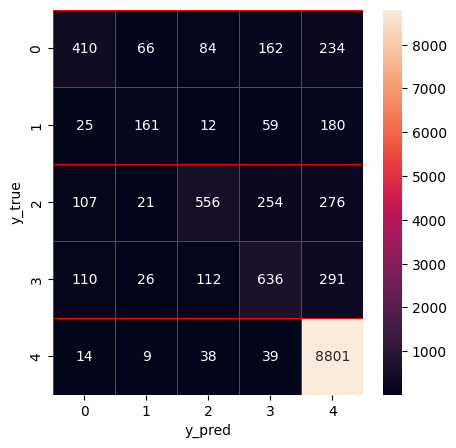

Final Detection Rate (DR) on Test Set: 0.9782
Final False Alarm Rate (FAR) on Test Set: 0.5711



In [23]:
xg = xgb.XGBClassifier(learning_rate=0.8324057811677461, n_estimators=75, max_depth = 58)

kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=0)
scores = cross_val_score(xg, X_train, y_train, cv=kfold, scoring='accuracy')

print("--- Tenfold Cross-Validation Results ---")
print(f"Scores for each fold: {scores}")
print(f"Average Accuracy: {np.mean(scores):.4f} (+/- {np.std(scores):.4f})\n")

xg.fit(X_train,y_train)
xg_score=xg.score(X_test,y_test)
y_predict=xg.predict(X_test)
y_true=y_test

print('Accuracy of XGBoost: '+ str(xg_score))

precision,recall,fscore,none= precision_recall_fscore_support(y_true, y_predict, average='weighted')

print('Precision of XGBoost: '+(str(precision)))
print('Recall of XGBoost: '+(str(recall)))
print('F1-score of XGBoost: '+(str(fscore)))

print(classification_report(y_true,y_predict))

cm=confusion_matrix(y_true,y_predict)
f,ax=plt.subplots(figsize=(5,5))

sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

tn = cm[0,0]
fp = cm[0,1:].sum()
fn = cm[1:,0].sum()
tp = cm[1:,1:].sum()

def far_score_multiclass(y_true, y_predict):
    """
    Calculates the False Alarm Rate for a multi-class confusion matrix.
    Assumes class 0 is the "Normal" or negative class.
    """
    cm = confusion_matrix(y_true, y_predict)

    tn = cm[0, 0]

    fp = cm[0, 1:].sum()
    
    false_alarm_rate = fp / (fp + tn) if (fp + tn) > 0 else 0.0
    
    return false_alarm_rate

detection_rate = tp / (tp + fn) if (tp + fn) > 0 else 0.0
false_alarm_rate = far_score_multiclass(y_true, y_predict)

print(f"Final Detection Rate (DR) on Test Set: {detection_rate:.4f}")
print(f"Final False Alarm Rate (FAR) on Test Set: {false_alarm_rate:.4f}\n")


In [24]:
xg_train=xg.predict(X_train)
xg_test=xg.predict(X_test)

#### Apply RF

Accuracy of RF: 0.8336355751793739
Precision of RF: 0.8158725417105068
Recall of RF: 0.8336355751793739
F1-score of RF: 0.8187636606490928
              precision    recall  f1-score   support

           0       0.62      0.44      0.51       956
           1       0.59      0.37      0.45       437
           2       0.70      0.46      0.55      1214
           3       0.56      0.54      0.55      1175
           4       0.90      0.99      0.94      8901

    accuracy                           0.83     12683
   macro avg       0.67      0.56      0.60     12683
weighted avg       0.82      0.83      0.82     12683



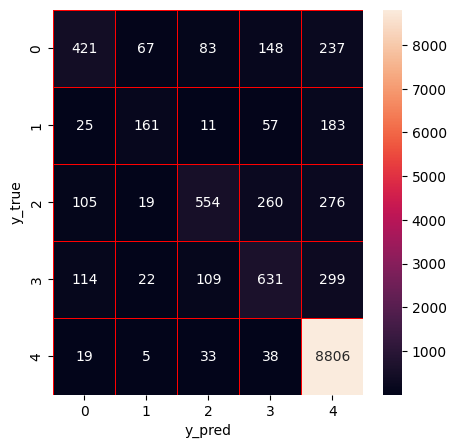

In [25]:
rf = RandomForestClassifier(random_state = 0)
rf.fit(X_train,y_train)
rf_score=rf.score(X_test,y_test)
y_predict=rf.predict(X_test)
y_true=y_test

print('Accuracy of RF: '+ str(rf_score))

precision,recall,fscore,none= precision_recall_fscore_support(y_true, y_predict, average='weighted')

print('Precision of RF: '+(str(precision)))
print('Recall of RF: '+(str(recall)))
print('F1-score of RF: '+(str(fscore)))

print(classification_report(y_true,y_predict))

cm=confusion_matrix(y_true,y_predict)
f,ax=plt.subplots(figsize=(5,5))

sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

#### Hyperparameter optimization (HPO) of random forest using Bayesian optimization with tree-based Parzen estimator (BO-TPE)
Based on the GitHub repo for HPO: https://github.com/LiYangHart/Hyperparameter-Optimization-of-Machine-Learning-Algorithms

In [26]:
# Hyperparameter optimization of random forest
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
from sklearn.model_selection import cross_val_score, StratifiedKFold

# Define the objective function
def objective(params):
    params = {
        'n_estimators': int(params['n_estimators']),
        'max_depth': int(params['max_depth']),
        'max_features': int(params['max_features']),
        "min_samples_split":int(params['min_samples_split']),
        "min_samples_leaf":int(params['min_samples_leaf']),
        "criterion":str(params['criterion'])
    }
    clf = RandomForestClassifier( **params)
    clf.fit(X_train_hpo,y_train_hpo)
    score=clf.score(X_val_hpo,y_val_hpo)

    return {'loss':-score, 'status': STATUS_OK }

# Define the hyperparameter configuration space
space = {
    'n_estimators': hp.quniform('n_estimators', 10, 200, 1),
    'max_depth': hp.quniform('max_depth', 5, 50, 1),
    "max_features":hp.quniform('max_features', 1, 20, 1),
    "min_samples_split":hp.quniform('min_samples_split',2,11,1),
    "min_samples_leaf":hp.quniform('min_samples_leaf',1,11,1),
    "criterion":hp.choice('criterion',['gini','entropy'])
}

best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=20)
            
print("Random Forest: Hyperopt estimated optimum {}".format(best))

100%|██████████| 20/20 [01:13<00:00,  3.67s/trial, best loss: -0.8364864864864865]
Random Forest: Hyperopt estimated optimum {'criterion': 0, 'max_depth': 24.0, 'max_features': 4.0, 'min_samples_leaf': 7.0, 'min_samples_split': 8.0, 'n_estimators': 64.0}


In [28]:
criteria = ['gini', 'entropy']

--- Tenfold Cross-Validation Results ---
Scores for each fold: [0.83851351 0.83981075 0.84183846 0.83643123 0.84251436 0.82933423
 0.8408246  0.83001014 0.83879689 0.83305171]
Average Accuracy: 0.8371 (+/- 0.0045)

Accuracy of RF: 0.8380509343215328
Precision of RF: 0.819781954323198
Recall of RF: 0.8380509343215328
F1-score of RF: 0.8223868762066158
              precision    recall  f1-score   support

           0       0.66      0.47      0.55       956
           1       0.54      0.38      0.44       437
           2       0.72      0.46      0.56      1214
           3       0.58      0.51      0.54      1175
           4       0.90      1.00      0.94      8901

    accuracy                           0.84     12683
   macro avg       0.68      0.56      0.61     12683
weighted avg       0.82      0.84      0.82     12683



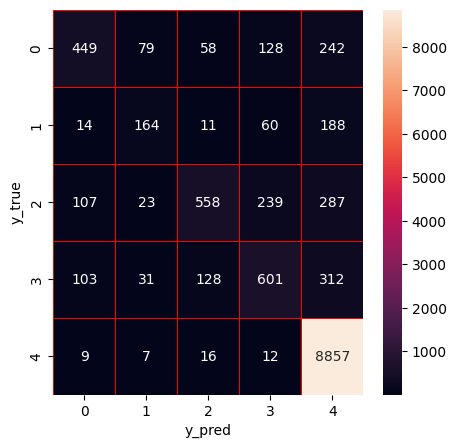

Final Detection Rate (DR) on Test Set: 0.9801
Final False Alarm Rate (FAR) on Test Set: 0.5303



In [29]:
rf_hpo = RandomForestClassifier(n_estimators = 64, min_samples_leaf = 7, max_depth = 24, min_samples_split = 8, max_features = 4, criterion = criteria[best['criterion']])

kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=0)
scores = cross_val_score(rf_hpo, X_train, y_train, cv=kfold, scoring='accuracy')

print("--- Tenfold Cross-Validation Results ---")
print(f"Scores for each fold: {scores}")
print(f"Average Accuracy: {np.mean(scores):.4f} (+/- {np.std(scores):.4f})\n")

rf_hpo.fit(X_train,y_train)
rf_score=rf_hpo.score(X_test,y_test)
y_predict=rf_hpo.predict(X_test)
y_true=y_test

print('Accuracy of RF: '+ str(rf_score))

precision,recall,fscore,none= precision_recall_fscore_support(y_true, y_predict, average='weighted')

print('Precision of RF: '+(str(precision)))
print('Recall of RF: '+(str(recall)))
print('F1-score of RF: '+(str(fscore)))
print(classification_report(y_true,y_predict))

cm=confusion_matrix(y_true,y_predict)
f,ax=plt.subplots(figsize=(5,5))

sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

tn = cm[0,0]
fp = cm[0,1:].sum()
fn = cm[1:,0].sum()
tp = cm[1:,1:].sum()


def far_score_multiclass(y_true, y_predict):
    """
    Calculates the False Alarm Rate for a multi-class confusion matrix.
    Assumes class 0 is the "Normal" or negative class.
    """
    cm = confusion_matrix(y_true, y_predict)

    tn = cm[0, 0]

    fp = cm[0, 1:].sum()
    
    false_alarm_rate = fp / (fp + tn) if (fp + tn) > 0 else 0.0
    
    return false_alarm_rate


detection_rate = tp / (tp + fn) if (tp + fn) > 0 else 0.0
false_alarm_rate = far_score_multiclass(y_true, y_predict)

print(f"Final Detection Rate (DR) on Test Set: {detection_rate:.4f}")
print(f"Final False Alarm Rate (FAR) on Test Set: {false_alarm_rate:.4f}\n")


In [30]:
rf_train=rf_hpo.predict(X_train)
rf_test=rf_hpo.predict(X_test)

#### Apply DT

Accuracy of DT: 0.8290625246392809
Precision of DT: 0.8117825178884482
Recall of DT: 0.8290625246392809
F1-score of DT: 0.8155914747245517
              precision    recall  f1-score   support

           0       0.60      0.45      0.51       956
           1       0.56      0.38      0.45       437
           2       0.69      0.46      0.55      1214
           3       0.54      0.53      0.54      1175
           4       0.90      0.98      0.94      8901

    accuracy                           0.83     12683
   macro avg       0.66      0.56      0.60     12683
weighted avg       0.81      0.83      0.82     12683



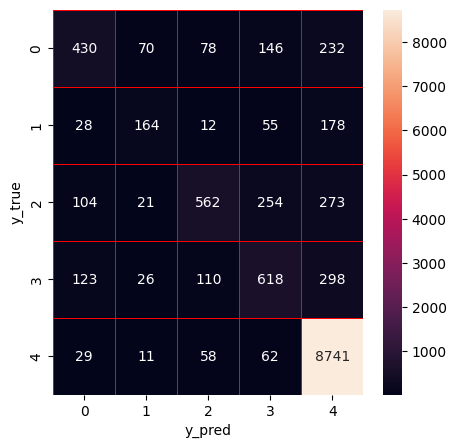

In [31]:
dt = DecisionTreeClassifier(random_state = 0)
dt.fit(X_train,y_train)
dt_score=dt.score(X_test,y_test)
y_predict=dt.predict(X_test)
y_true=y_test

print('Accuracy of DT: '+ str(dt_score))

precision,recall,fscore,none= precision_recall_fscore_support(y_true, y_predict, average='weighted')

print('Precision of DT: '+(str(precision)))
print('Recall of DT: '+(str(recall)))
print('F1-score of DT: '+(str(fscore)))

print(classification_report(y_true,y_predict))

cm=confusion_matrix(y_true,y_predict)
f,ax=plt.subplots(figsize=(5,5))

sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

#### Hyperparameter optimization (HPO) of decision tree using Bayesian optimization with tree-based Parzen estimator (BO-TPE)
Based on the GitHub repo for HPO: https://github.com/LiYangHart/Hyperparameter-Optimization-of-Machine-Learning-Algorithms

In [32]:
# Hyperparameter optimization of decision tree
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
from sklearn.model_selection import cross_val_score, StratifiedKFold
# Define the objective function
def objective(params):
    params = {
        'max_depth': int(params['max_depth']),
        'max_features': int(params['max_features']),
        "min_samples_split":int(params['min_samples_split']),
        "min_samples_leaf":int(params['min_samples_leaf']),
        "criterion":str(params['criterion'])
    }
    clf = DecisionTreeClassifier( **params)
    clf.fit(X_train,y_train)
    score=clf.score(X_val_hpo,y_val_hpo)

    return {'loss':-score, 'status': STATUS_OK }
    
# Define the hyperparameter configuration space
space = {
    'max_depth': hp.quniform('max_depth', 5, 50, 1),
    "max_features":hp.quniform('max_features', 1, 20, 1),
    "min_samples_split":hp.quniform('min_samples_split',2,11,1),
    "min_samples_leaf":hp.quniform('min_samples_leaf',1,11,1),
    "criterion":hp.choice('criterion',['gini','entropy'])
}

best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=50)
print("Decision tree: Hyperopt estimated optimum {}".format(best))

100%|██████████| 50/50 [00:02<00:00, 19.22trial/s, best loss: -0.8756756756756757]
Decision tree: Hyperopt estimated optimum {'criterion': 0, 'max_depth': 49.0, 'max_features': 11.0, 'min_samples_leaf': 1.0, 'min_samples_split': 2.0}


--- Tenfold Cross-Validation Results ---
Scores for each fold: [0.82871622 0.82764447 0.82832038 0.81919567 0.82730652 0.81953363
 0.83271375 0.82088543 0.82460291 0.82426495]
Average Accuracy: 0.8253 (+/- 0.0042)

Accuracy of DT: 0.8282740676496098
Precision of DT: 0.811019032953927
Recall of DT: 0.8282740676496098
F1-score of DT: 0.8149828012536372
              precision    recall  f1-score   support

           0       0.60      0.45      0.52       956
           1       0.56      0.38      0.45       437
           2       0.68      0.46      0.55      1214
           3       0.54      0.52      0.53      1175
           4       0.90      0.98      0.94      8901

    accuracy                           0.83     12683
   macro avg       0.66      0.56      0.60     12683
weighted avg       0.81      0.83      0.81     12683



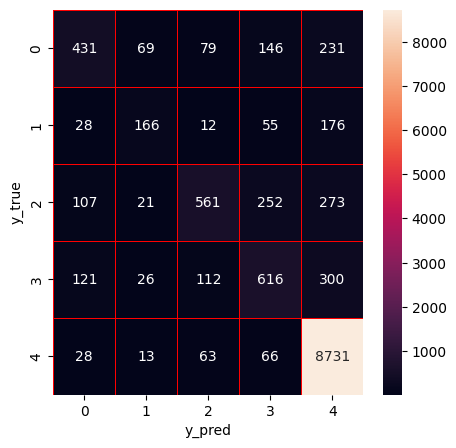

Final Detection Rate (DR) on Test Set: 0.9758
Final False Alarm Rate (FAR) on Test Set: 0.5492



In [33]:
dt_hpo = DecisionTreeClassifier(min_samples_leaf = 1, max_depth = 49, min_samples_split = 2, max_features = 11, criterion = criteria[best['criterion']])

kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=0)
scores = cross_val_score(dt_hpo, X_train, y_train, cv=kfold, scoring='accuracy')

print("--- Tenfold Cross-Validation Results ---")
print(f"Scores for each fold: {scores}")
print(f"Average Accuracy: {np.mean(scores):.4f} (+/- {np.std(scores):.4f})\n")

dt_hpo.fit(X_train,y_train)
dt_score=dt_hpo.score(X_test,y_test)
y_predict=dt_hpo.predict(X_test)
y_true=y_test

print('Accuracy of DT: '+ str(dt_score))

precision,recall,fscore,none= precision_recall_fscore_support(y_true, y_predict, average='weighted')

print('Precision of DT: '+(str(precision)))
print('Recall of DT: '+(str(recall)))
print('F1-score of DT: '+(str(fscore)))

print(classification_report(y_true,y_predict))
cm=confusion_matrix(y_true,y_predict)
f,ax=plt.subplots(figsize=(5,5))

sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

tn = cm[0,0]
fp = cm[0,1:].sum()
fn = cm[1:,0].sum()
tp = cm[1:,1:].sum()

def far_score_multiclass(y_true, y_predict):
    """
    Calculates the False Alarm Rate for a multi-class confusion matrix.
    Assumes class 0 is the "Normal" or negative class.
    """
    cm = confusion_matrix(y_true, y_predict)

    tn = cm[0, 0]

    fp = cm[0, 1:].sum()
    
    false_alarm_rate = fp / (fp + tn) if (fp + tn) > 0 else 0.0
    
    return false_alarm_rate


detection_rate = tp / (tp + fn) if (tp + fn) > 0 else 0.0
false_alarm_rate = far_score_multiclass(y_true, y_predict)

print(f"Final Detection Rate (DR) on Test Set: {detection_rate:.4f}")
print(f"Final False Alarm Rate (FAR) on Test Set: {false_alarm_rate:.4f}\n")


In [34]:
dt_train=dt_hpo.predict(X_train)
dt_test=dt_hpo.predict(X_test)

#### Apply ET

Accuracy of ET: 0.8313490499093275
Precision of ET: 0.813544204161237
Recall of ET: 0.8313490499093275
F1-score of ET: 0.81752941197052
              precision    recall  f1-score   support

           0       0.61      0.45      0.52       956
           1       0.56      0.37      0.45       437
           2       0.68      0.46      0.55      1214
           3       0.56      0.54      0.55      1175
           4       0.90      0.98      0.94      8901

    accuracy                           0.83     12683
   macro avg       0.66      0.56      0.60     12683
weighted avg       0.81      0.83      0.82     12683



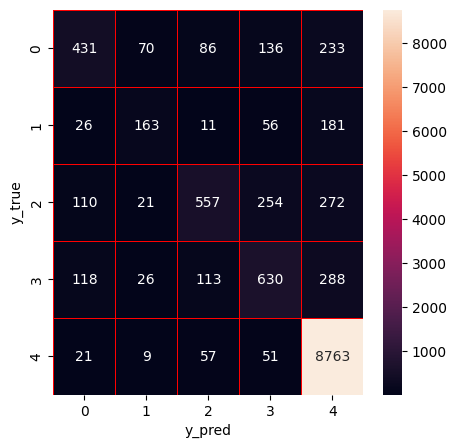

In [35]:
et = ExtraTreesClassifier(random_state = 0)
et.fit(X_train,y_train)
et_score=et.score(X_test,y_test)
y_predict=et.predict(X_test)
y_true=y_test

print('Accuracy of ET: '+ str(et_score))

precision,recall,fscore,none= precision_recall_fscore_support(y_true, y_predict, average='weighted')

print('Precision of ET: '+(str(precision)))
print('Recall of ET: '+(str(recall)))
print('F1-score of ET: '+(str(fscore)))

print(classification_report(y_true,y_predict))

cm=confusion_matrix(y_true,y_predict)
f,ax=plt.subplots(figsize=(5,5))

sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

#### Hyperparameter optimization (HPO) of extra trees using Bayesian optimization with tree-based Parzen estimator (BO-TPE)
Based on the GitHub repo for HPO: https://github.com/LiYangHart/Hyperparameter-Optimization-of-Machine-Learning-Algorithms

In [36]:
# Hyperparameter optimization of extra trees
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
from sklearn.model_selection import cross_val_score, StratifiedKFold
# Define the objective function
def objective(params):
    params = {
        'n_estimators': int(params['n_estimators']),
        'max_depth': int(params['max_depth']),
        'max_features': int(params['max_features']),
        "min_samples_split":int(params['min_samples_split']),
        "min_samples_leaf":int(params['min_samples_leaf']),
        "criterion":str(params['criterion'])
    }
    clf = ExtraTreesClassifier( **params)
    clf.fit(X_train,y_train)
    score=clf.score(X_val_hpo,y_val_hpo)

    return {'loss':-score, 'status': STATUS_OK }
    
# Define the hyperparameter configuration space
space = {
    'n_estimators': hp.quniform('n_estimators', 10, 200, 1),
    'max_depth': hp.quniform('max_depth', 5, 50, 1),
    "max_features":hp.quniform('max_features', 1, 20, 1),
    "min_samples_split":hp.quniform('min_samples_split',2,11,1),
    "min_samples_leaf":hp.quniform('min_samples_leaf',1,11,1),
    "criterion":hp.choice('criterion',['gini','entropy'])
}

best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=20)
print("Random Forest: Hyperopt estimated optimum {}".format(best))

100%|██████████| 20/20 [00:30<00:00,  1.54s/trial, best loss: -0.8587837837837838]
Random Forest: Hyperopt estimated optimum {'criterion': 0, 'max_depth': 37.0, 'max_features': 14.0, 'min_samples_leaf': 3.0, 'min_samples_split': 9.0, 'n_estimators': 42.0}


--- Tenfold Cross-Validation Results ---
Scores for each fold: [0.83986486 0.83541737 0.83710713 0.83541737 0.83507942 0.82595471
 0.83879689 0.82764447 0.83643123 0.83203785]
Average Accuracy: 0.8344 (+/- 0.0043)

Accuracy of ET: 0.8373413230308286
Precision of ET: 0.8200385406053139
Recall of ET: 0.8373413230308286
F1-score of ET: 0.822332691305857
              precision    recall  f1-score   support

           0       0.63      0.47      0.54       956
           1       0.56      0.37      0.45       437
           2       0.73      0.46      0.57      1214
           3       0.57      0.53      0.55      1175
           4       0.90      0.99      0.94      8901

    accuracy                           0.84     12683
   macro avg       0.68      0.56      0.61     12683
weighted avg       0.82      0.84      0.82     12683



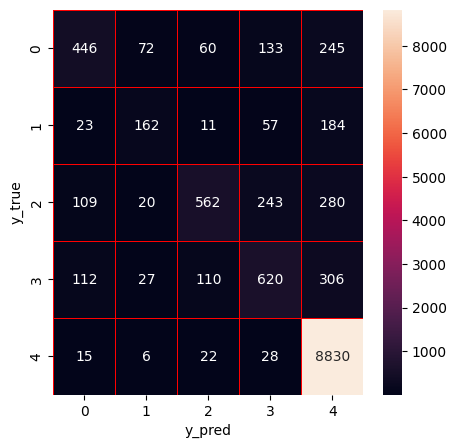

Final Detection Rate (DR) on Test Set: 0.9779
Final False Alarm Rate (FAR) on Test Set: 0.5335



In [37]:
et_hpo = ExtraTreesClassifier(n_estimators = 42, min_samples_leaf = 1, max_depth = 37, min_samples_split = 9, criterion=criteria[best['criterion']])
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=0)
scores = cross_val_score(et_hpo, X_train, y_train, cv=kfold, scoring='accuracy')

print("--- Tenfold Cross-Validation Results ---")
print(f"Scores for each fold: {scores}")
print(f"Average Accuracy: {np.mean(scores):.4f} (+/- {np.std(scores):.4f})\n")

et_hpo.fit(X_train,y_train)
et_score=et_hpo.score(X_test,y_test)
y_predict=et_hpo.predict(X_test)
y_true=y_test

print('Accuracy of ET: '+ str(et_score))

precision,recall,fscore,none= precision_recall_fscore_support(y_true, y_predict, average='weighted')

print('Precision of ET: '+(str(precision)))
print('Recall of ET: '+(str(recall)))
print('F1-score of ET: '+(str(fscore)))

print(classification_report(y_true,y_predict))

cm=confusion_matrix(y_true,y_predict)
f,ax=plt.subplots(figsize=(5,5))

sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

tn = cm[0,0]
fp = cm[0,1:].sum()
fn = cm[1:,0].sum()
tp = cm[1:,1:].sum()

def far_score_multiclass(y_true, y_predict):
    """
    Calculates the False Alarm Rate for a multi-class confusion matrix.
    Assumes class 0 is the "Normal" or negative class.
    """
    cm = confusion_matrix(y_true, y_predict)

    tn = cm[0, 0]

    fp = cm[0, 1:].sum()
    
    false_alarm_rate = fp / (fp + tn) if (fp + tn) > 0 else 0.0
    
    return false_alarm_rate


detection_rate = tp / (tp + fn) if (tp + fn) > 0 else 0.0
false_alarm_rate = far_score_multiclass(y_true, y_predict)

print(f"Final Detection Rate (DR) on Test Set: {detection_rate:.4f}")
print(f"Final False Alarm Rate (FAR) on Test Set: {false_alarm_rate:.4f}\n")


In [38]:
et_train=et_hpo.predict(X_train)
et_test=et_hpo.predict(X_test)

### Apply Stacking
The ensemble model that combines the four ML models (DT, RF, ET, XGBoost)

In [39]:
base_predictions_train = pd.DataFrame( {
    'DecisionTree': dt_train.ravel(),
        'RandomForest': rf_train.ravel(),
     'ExtraTrees': et_train.ravel(),
     'XgBoost': xg_train.ravel(),
    })
base_predictions_train.head(5)

,DecisionTree,RandomForest,ExtraTrees,XgBoost
0,4,4,4,4
1,2,2,2,2
2,3,3,3,3
3,4,4,4,4
4,4,4,4,4


In [40]:
dt_train=dt_train.reshape(-1, 1)
et_train=et_train.reshape(-1, 1)
rf_train=rf_train.reshape(-1, 1)
xg_train=xg_train.reshape(-1, 1)
dt_test=dt_test.reshape(-1, 1)
et_test=et_test.reshape(-1, 1)
rf_test=rf_test.reshape(-1, 1)
xg_test=xg_test.reshape(-1, 1)

In [41]:
dt_train.shape

(29591, 1)

In [42]:
x_train = np.concatenate(( dt_train, et_train, rf_train, xg_train), axis=1)
x_test = np.concatenate(( dt_test, et_test, rf_test, xg_test), axis=1)

Accuracy of Stacking: 0.8307971300165576
Precision of Stacking: 0.8126213672149458
Recall of Stacking: 0.8307971300165576
F1-score of Stacking: 0.816736405990429
              precision    recall  f1-score   support

           0       0.61      0.44      0.51       956
           1       0.57      0.37      0.45       437
           2       0.68      0.46      0.55      1214
           3       0.55      0.53      0.54      1175
           4       0.90      0.99      0.94      8901

    accuracy                           0.83     12683
   macro avg       0.66      0.56      0.60     12683
weighted avg       0.81      0.83      0.82     12683



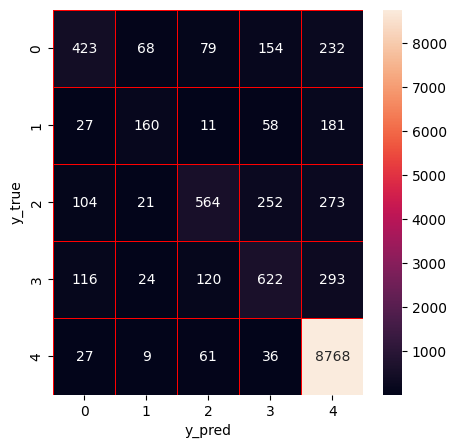

In [43]:
stk = xgb.XGBClassifier().fit(x_train, y_train)
y_predict=stk.predict(x_test)
y_true=y_test
stk_score=accuracy_score(y_true,y_predict)

print('Accuracy of Stacking: '+ str(stk_score))

precision,recall,fscore,none= precision_recall_fscore_support(y_true, y_predict, average='weighted')

print('Precision of Stacking: '+(str(precision)))
print('Recall of Stacking: '+(str(recall)))
print('F1-score of Stacking: '+(str(fscore)))

print(classification_report(y_true,y_predict))

cm=confusion_matrix(y_true,y_predict)
f,ax=plt.subplots(figsize=(5,5))

sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

#### Hyperparameter optimization (HPO) of the stacking ensemble model (XGBoost) using Bayesian optimization with tree-based Parzen estimator (BO-TPE)
Based on the GitHub repo for HPO: https://github.com/LiYangHart/Hyperparameter-Optimization-of-Machine-Learning-Algorithms

In [44]:
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
from sklearn.model_selection import cross_val_score, StratifiedKFold

def objective(params):
    params = {
        'n_estimators': int(params['n_estimators']),
        'max_depth': int(params['max_depth']),
        'learning_rate':  abs(float(params['learning_rate'])),

    }
    clf = xgb.XGBClassifier( **params)
    clf.fit(X_train_hpo, y_train_hpo)
    y_pred = clf.predict(X_val_hpo)
    score = accuracy_score(y_val_hpo, y_pred)

    return {'loss':-score, 'status': STATUS_OK }

space = {
    'n_estimators': hp.quniform('n_estimators', 10, 100, 5),
    'max_depth': hp.quniform('max_depth', 4, 100, 1),
    'learning_rate': hp.normal('learning_rate', 0.01, 0.9),
}

best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=20)
print("XGBoost: Hyperopt estimated optimum {}".format(best))

100%|██████████| 20/20 [00:36<00:00,  1.83s/trial, best loss: -0.8361486486486487]
XGBoost: Hyperopt estimated optimum {'learning_rate': -0.04992704617748181, 'max_depth': 16.0, 'n_estimators': 55.0}


--- Tenfold Cross-Validation Results ---
Scores for each fold: [0.84594595 0.83710713 0.83947279 0.83575532 0.84048665 0.83034809
 0.84183846 0.83338966 0.83879689 0.83305171]
Average Accuracy: 0.8376 (+/- 0.0044)

Accuracy of XGBoost: 0.8309548214144918
Precision of XGBoost: 0.8140233148586138
Recall of XGBoost: 0.8309548214144918
F1-score of XGBoost: 0.8169608426029836
              precision    recall  f1-score   support

           0       0.62      0.44      0.51       956
           1       0.56      0.37      0.44       437
           2       0.70      0.46      0.56      1214
           3       0.54      0.53      0.53      1175
           4       0.90      0.99      0.94      8901

    accuracy                           0.83     12683
   macro avg       0.66      0.56      0.60     12683
weighted avg       0.81      0.83      0.82     12683



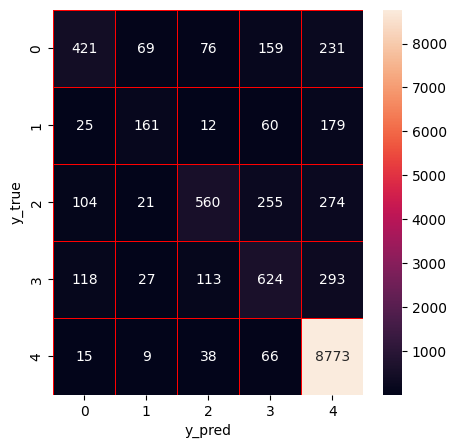

Final Detection Rate (DR) on Test Set: 0.9777
Final False Alarm Rate (FAR) on Test Set: 0.5596



In [45]:
xg = xgb.XGBClassifier(learning_rate=0.04992704617748181, n_estimators = 55, max_depth = 16)

kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=0)
scores = cross_val_score(xg, X_train, y_train, cv=kfold, scoring='accuracy')

print("--- Tenfold Cross-Validation Results ---")
print(f"Scores for each fold: {scores}")
print(f"Average Accuracy: {np.mean(scores):.4f} (+/- {np.std(scores):.4f})\n")

xg.fit(x_train,y_train)
xg_score=xg.score(x_test,y_test)
y_predict=xg.predict(x_test)
y_true=y_test

print('Accuracy of XGBoost: '+ str(xg_score))

precision,recall,fscore,none= precision_recall_fscore_support(y_true, y_predict, average='weighted')

print('Precision of XGBoost: '+(str(precision)))
print('Recall of XGBoost: '+(str(recall)))
print('F1-score of XGBoost: '+(str(fscore)))

print(classification_report(y_true,y_predict))

cm=confusion_matrix(y_true,y_predict)
f,ax=plt.subplots(figsize=(5,5))

sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

tn = cm[0,0]
fp = cm[0,1:].sum()
fn = cm[1:,0].sum()
tp = cm[1:,1:].sum()

def far_score_multiclass(y_true, y_predict):
    """
    Calculates the False Alarm Rate for a multi-class confusion matrix.
    Assumes class 0 is the "Normal" or negative class.
    """
    cm = confusion_matrix(y_true, y_predict)

    tn = cm[0, 0]

    fp = cm[0, 1:].sum()
    
    false_alarm_rate = fp / (fp + tn) if (fp + tn) > 0 else 0.0
    
    return false_alarm_rate


detection_rate = tp / (tp + fn) if (tp + fn) > 0 else 0.0
false_alarm_rate = far_score_multiclass(y_true, y_predict)

print(f"Final Detection Rate (DR) on Test Set: {detection_rate:.4f}")
print(f"Final False Alarm Rate (FAR) on Test Set: {false_alarm_rate:.4f}\n")
